In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os.path import join as pjoin
data_root =  '../input/gaflattenv2'
print(os.listdir(data_root))

# Any results you write to the current directory are saved as output.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)

# Load data

In [ ]:
sub = pd.read_csv('../input/ga-customer-revenue-prediction/sample_submission_v2.csv',
                       nrows=100000,dtype={'fullVisitorId':'str'})

In [ ]:
def load_data(nrows=100000):
    global df_train , df_test
    print('Loading data')
    df_train = pd.read_csv(pjoin(data_root,"train_v2_flat.csv"),
                       nrows=nrows,dtype={'fullVisitorId':'str'})
    df_test = pd.read_csv(pjoin(data_root,"test_v2_flat.csv"),
                       nrows=nrows,dtype={'fullVisitorId':'str'})
    
    print('Log the totals_transactionRevenue')
    df_train.totals_transactionRevenue = df_train.totals_transactionRevenue.apply(np.log1p)
    
    print('Drop the revenue and trafficSource_campaignCode columns')
    # This test data contains the actual revenue but will we delete it and pretend we don't know about that
    df_train.drop(['totals_totalTransactionRevenue','totals_transactions','trafficSource_campaignCode'],axis=1,inplace=True)
    df_test.drop(['totals_transactionRevenue','totals_totalTransactionRevenue','totals_transactions'],axis=1,inplace=True)
    
    print(df_train.shape,df_test.shape)
    
    

In [107]:
load_data(nrows=None)

Load data
Log the totals_transactionRevenue
Drop the revenue and trafficSource_campaignCode columns
(100000, 36) (100000, 35)


## Data overview

In [103]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 36 columns):
channelGrouping                                 100000 non-null object
date                                            100000 non-null int64
fullVisitorId                                   100000 non-null object
visitId                                         100000 non-null int64
visitNumber                                     100000 non-null int64
visitStartTime                                  100000 non-null int64
device_browser                                  100000 non-null object
device_deviceCategory                           100000 non-null object
device_isMobile                                 100000 non-null bool
device_operatingSystem                          100000 non-null object
geoNetwork_city                                 100000 non-null object
geoNetwork_continent                            100000 non-null object
geoNetwork_country                          

In [102]:
df_train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1.0,1,1.0,1.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2.0,2.0,28.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1.0,2.0,1.0,38.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1.0,2.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1.0,2.0,1.0,52.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


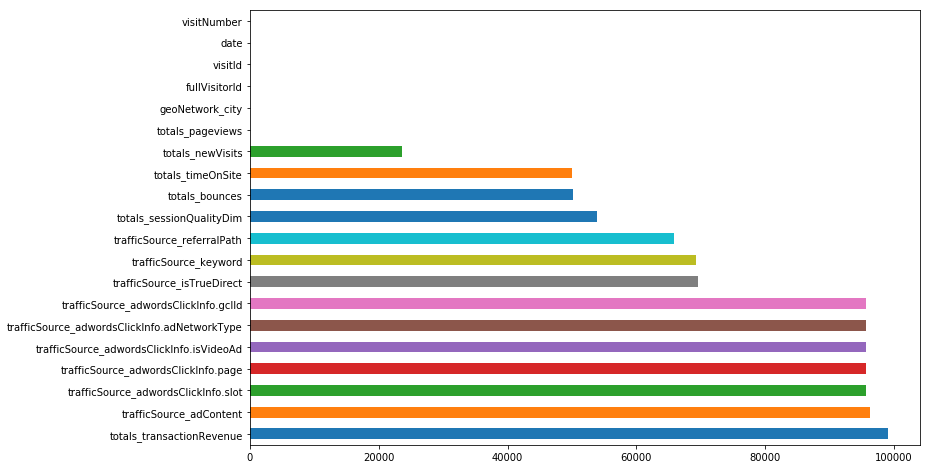

In [96]:
df_train.isnull().sum().sort_values(ascending=False)[:20].plot(kind='barh')

# Examine the null values 

In [144]:
na_cols = df_train.isnull().sum().sort_values(ascending=False).index
na_cols

Index(['trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.slot',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.gclId', 'trafficSource_isTrueDirect',
       'trafficSource_keyword', 'trafficSource_referralPath',
       'totals_sessionQualityDim', 'totals_bounces', 'totals_timeOnSite',
       'totals_newVisits', 'totals_pageviews', 'device_deviceCategory',
       'device_browser', 'device_isMobile', 'visitStartTime', 'visitId',
       'visitNumber', 'geoNetwork_city', 'fullVisitorId', 'date',
       'device_operatingSystem', 'trafficSource_source',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_hits', 'totals_transactionRevenue',
       'trafficSource_campaign', 'trafficSource_medium', 'channelGrouping'],
   

In [138]:
def lookatit(col,df=df_train):
    """ Brief the status of feature """
    # percentile of nan
    # # unique values
    s = df_train[col]
    print(f"{s.nunique()} unique values")
    print(f"{s.isnull().sum()*100/len(s)}% are na")
    print(list(s.value_counts(ascending=False).index[:3]))
    print('-'*100)

## Replace the na str

In [136]:
cols_to_replace = {
    'socialEngagementType' : 'Not Socially Engaged',
    'device_browserSize' : 'not available in demo dataset', 
    'device_flashVersion' : 'not available in demo dataset', 
    'device_browserVersion' : 'not available in demo dataset', 
    'device_language' : 'not available in demo dataset',
    'device_mobileDeviceBranding' : 'not available in demo dataset',
    'device_mobileDeviceInfo' : 'not available in demo dataset',
    'device_mobileDeviceMarketingName' : 'not available in demo dataset',
    'device_mobileDeviceModel' : 'not available in demo dataset',
    'device_mobileInputSelector' : 'not available in demo dataset',
    'device_operatingSystemVersion' : 'not available in demo dataset',
    'device_screenColors' : 'not available in demo dataset',
    'device_screenResolution' : 'not available in demo dataset',
    'geoNetwork_city' : 'not available in demo dataset',
    'geoNetwork_cityId' : 'not available in demo dataset',
    'geoNetwork_latitude' : 'not available in demo dataset',
    'geoNetwork_longitude' : 'not available in demo dataset',
    'geoNetwork_metro' : ['not available in demo dataset', '(not set)'], 
    'geoNetwork_networkDomain' : 'unknown.unknown', 
    'geoNetwork_networkLocation' : 'not available in demo dataset',
    'geoNetwork_region' : 'not available in demo dataset',
    'trafficSource_adwordsClickInfo.criteriaParameters' : 'not available in demo dataset',
    'trafficSource_campaign' : '(not set)', 
    'trafficSource_keyword' : '(not provided)'
}

In [137]:
df_train = df_train.replace(cols_to_replace,'NA')
df_test = df_train.replace(cols_to_replace,'NA')

## Fillna with the right values

In [145]:
for col in na_cols:
    print(col)
    lookatit(col)

trafficSource_adContent
54 unique values
96.237% are na
['Google Merchandise Store', 'Google Merchandise Collection', 'Placement Accessores 300 x 250']
----------------------------------------------------------------------------------------------------
trafficSource_adwordsClickInfo.adNetworkType
2 unique values
95.609% are na
['Content', 'Google Search']
----------------------------------------------------------------------------------------------------
trafficSource_adwordsClickInfo.slot
3 unique values
95.609% are na
['RHS', 'Top', 'Google Display Network']
----------------------------------------------------------------------------------------------------
trafficSource_adwordsClickInfo.page
6 unique values
95.609% are na
[1.0, 2.0, 3.0]
----------------------------------------------------------------------------------------------------
trafficSource_adwordsClickInfo.isVideoAd
1 unique values
95.609% are na
[False]
--------------------------------------------------------------------

In [149]:
# Each type of columsn that need to replace with the right na values
to_NA_cols = ['trafficSource_adContent','trafficSource_adwordsClickInfo.adNetworkType',
            'trafficSource_adwordsClickInfo.slot','trafficSource_adwordsClickInfo.gclId',
            'trafficSource_keyword','trafficSource_referralPath']

to_0_cols = ['totals_transactionRevenue','trafficSource_adwordsClickInfo.page','totals_sessionQualityDim','totals_bounces',
             'totals_timeOnSite','totals_newVisits','totals_pageviews']

to_true_cols = ['trafficSource_adwordsClickInfo.isVideoAd']
to_false_cols = ['trafficSource_isTrueDirect']

In [151]:
df_train[to_NA_cols] = df_train[to_NA_cols].fillna('NA')
df_train[to_0_cols] = df_train[to_0_cols].fillna(0)
df_train[to_true_cols] = df_train[to_true_cols].fillna(True)
df_train[to_false_cols] = df_train[to_false_cols].fillna(False)

df_test[to_NA_cols] = df_test[to_NA_cols].fillna('NA')
df_test[to_0_cols] = df_test[to_0_cols].fillna(0)
df_test[to_true_cols] = df_test[to_true_cols].fillna(True)
df_test[to_false_cols] = df_test[to_false_cols].fillna(False)


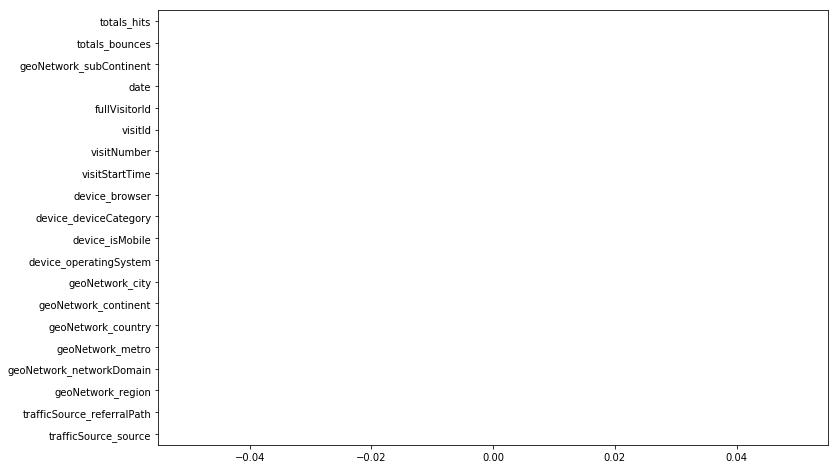

In [152]:
df_train.isnull().sum().sort_values(ascending=False)[:20].plot(kind='barh')

perfect

In [153]:
df_train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,NA,Europe,Germany,NA,(not set),NA,Western Europe,1.0,1,1.0,1.0,1.0,0.0,0.0,NA,NA,NA,True,0.0,NA,NA,False,water bottle,organic,NA,google
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,0.0,2,0.0,2.0,2.0,28.0,0.0,NA,NA,NA,True,0.0,NA,NA,False,NA,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,NA,Americas,United States,NA,windjammercable.net,NA,Northern America,0.0,2,1.0,2.0,1.0,38.0,0.0,NA,NA,NA,True,0.0,NA,NA,True,NA,(none),NA,(direct)
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,NA,Asia,Turkey,NA,NA,NA,Western Asia,0.0,2,1.0,2.0,1.0,1.0,0.0,NA,NA,NA,True,0.0,NA,NA,False,NA,organic,NA,google
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,NA,Americas,Mexico,NA,prod-infinitum.com.mx,NA,Central America,0.0,2,1.0,2.0,1.0,52.0,0.0,NA,NA,NA,True,0.0,NA,NA,False,NA,organic,NA,google


## Constant columns

In [155]:
for col in df_train.columns:
    if df_train[col].std == 0:
        print(col)

There are no more constant columns in this dataset

In [157]:
df_train.to_csv('train_cleaned.csv',index=False)
df_test.to_csv('test_cleaned.csv',index=False)